# LRS2 advanced reductions (LRS2Multi)

This notebook is an introduction to using LRS2Multi, which operates on Panacea multi*.fits products to perform advanced sky subtraction, object detection, object extraction, cube creation, or stacking multiple observations.  The details of the code can be found in https://github.com/grzeimann/LRS2Multi, and this notebook serves as a use-case demonstration.

The first cell is long and constructions functions to find data from a program(s) as well as load the necessary modules.  For the beginning, simply execute the first cell and move to the next step.  If you run into issues, please contact Greg Zeimann (gregz@astro.as.utexas.edu).

In [1]:
import sys
sys.path.append("..") 
from lrs2multi import LRS2Multi
from lrs2object import LRS2Object
import glob
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from datetime import datetime, timedelta


def get_scifiles_from_folder(folders, object_name=None, exclude_folder=[], date=None, ndays=None,
                              collect_standards=False):
    filenames = []
    if date is not None:
        def_name = 'multi*%s*orange.fits' % date
    else:
        def_name = 'multi*orange.fits'
    if ndays is not None:
        def_name = 'multi*%s*orange.fits'
    for folder in folders:
        if ndays is not None:
            date_ = datetime(int(date[:4]), int(date[4:6]), int(date[6:]))
            datel = date_ - timedelta(days=int(ndays/2))
            for i in np.arange(ndays):
                ndate = datel + timedelta(days=i)
                daten = '%04d%02d%02d' % (ndate.year, ndate.month, ndate.day)
                all_names = sorted(glob.glob(op.join(folder, def_name % daten)))
                for filename in all_names:
                    filenames.append(filename)
        else:
            all_names = sorted(glob.glob(op.join(folder, def_name)))
            for filename in all_names:
                filenames.append(filename)
    smaller_list = []
    names = []
    for filename in filenames:
        f = fits.open(filename)
        name = f[0].header['OBJECT']
        names.append(name)
        try:
            slot = name.split('_')[-2]
        except:
            continue
        if '_'.join(op.basename(filename).split('_')[:4]) in exclude_folder:
            continue
        if collect_standards:
            if name.lower() in standard_names:
                if slot == '056':
                    smaller_list.append(filename.replace('orange', 'uv'))
                    smaller_list.append(filename.replace('orange', 'orange'))
                if slot == '066':
                    smaller_list.append(filename.replace('orange', 'red'))
                    smaller_list.append(filename.replace('orange', 'farred'))
            continue
        if (object_name is None):
            if slot == '056':
                smaller_list.append(filename.replace('orange', 'uv'))
                smaller_list.append(filename.replace('orange', 'orange'))
            if slot == '066':
                smaller_list.append(filename.replace('orange', 'red'))
                smaller_list.append(filename.replace('orange', 'farred'))
        else:
            if object_name.lower() in name.lower():
                if slot == '056':
                    smaller_list.append(filename.replace('orange', 'uv'))
                    smaller_list.append(filename.replace('orange', 'orange'))
                if slot == '066':
                    smaller_list.append(filename.replace('orange', 'red'))
                    smaller_list.append(filename.replace('orange', 'farred'))
    return smaller_list, names

def get_scifiles_from_folder_from_pos(folders, object_name=None, exposure_min=None):
    filenames = []
    for folder in folders:
        all_names = sorted(glob.glob(op.join(folder, 'multi*.fits')))
        for filename in all_names:
            filenames.append(filename)
    smaller_list = []
    for filename in filenames:
        f = fits.open(filename)
        if ('uv' in filename) or ('orange' in filename):
            side = '056'
        else:
            side = '066'
        name = f[0].header['OBJECT']
        try:
            slot = name.split('_')[-2]
        except:
            continue
        name = 'J%s%s' % (''.join(f[0].header['QRA'].split(':')), ''.join(f[0].header['QDEC'].split(':')))
        if side != slot:
            continue
        if exposure_min is not None:
            if f[0].header['EXPTIME'] < exposure_min:
                continue
        if object_name is None:
            smaller_list.append(filename)
        else:
            if object_name.lower() in name.lower():
                smaller_list.append(filename)
    return smaller_list
    
sns.set_context('talk')
sns.set_style('ticks')
plt.rcParams["font.family"] = "Times New Roman"

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10
def_wave = np.arange(3650., 10500, 0.7)

# Example Reduction

Now that we have loaded the necessary modules, we can begin our own advanced reduction.  There are comments throughout the long cell below to show an example reduction.

[INFO - 2022-10-17 15:39:39,331] multi_20210325_0000002_exp01_uv: srlrs2_tst_056_W with 607.25s, 40.47cm2, 0.80
[INFO - 2022-10-17 15:39:39,671] multi_20210325_0000002_exp01_orange: srlrs2_tst_056_W with 607.25s, 40.47cm2, 0.80
[INFO - 2022-10-17 15:39:39,683] multi_20210325_0000002_exp01_orange.fits Centroid: -1.28 -2.15
[INFO - 2022-10-17 15:39:39,747] No fplane file given.
[INFO - 2022-10-17 15:39:39,747] Some functions will be unavailable until an fplane is given.
[INFO - 2022-10-17 15:39:39,750] No fplane file given.
[INFO - 2022-10-17 15:39:39,751] Some functions will be unavailable until an fplane is given.
[INFO - 2022-10-17 15:39:39,763] multi_20210325_0000002_exp01_orange.fits Centroid: -1.25 -2.15
[INFO - 2022-10-17 15:39:42,171] multi_20210325_0000002_exp01_orange.fits: 1.00
[INFO - 2022-10-17 15:39:42,192] SN for multi_20210325_0000002_exp01_orange.fits: 380.77
[INFO - 2022-10-17 15:39:42,360] multi_20210325_0000002_exp01_orange.fits Centroid: -1.31 -2.14


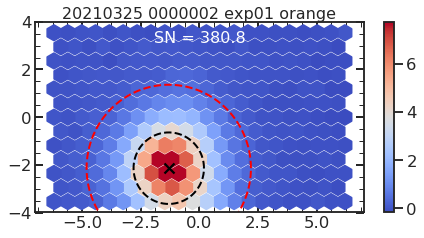

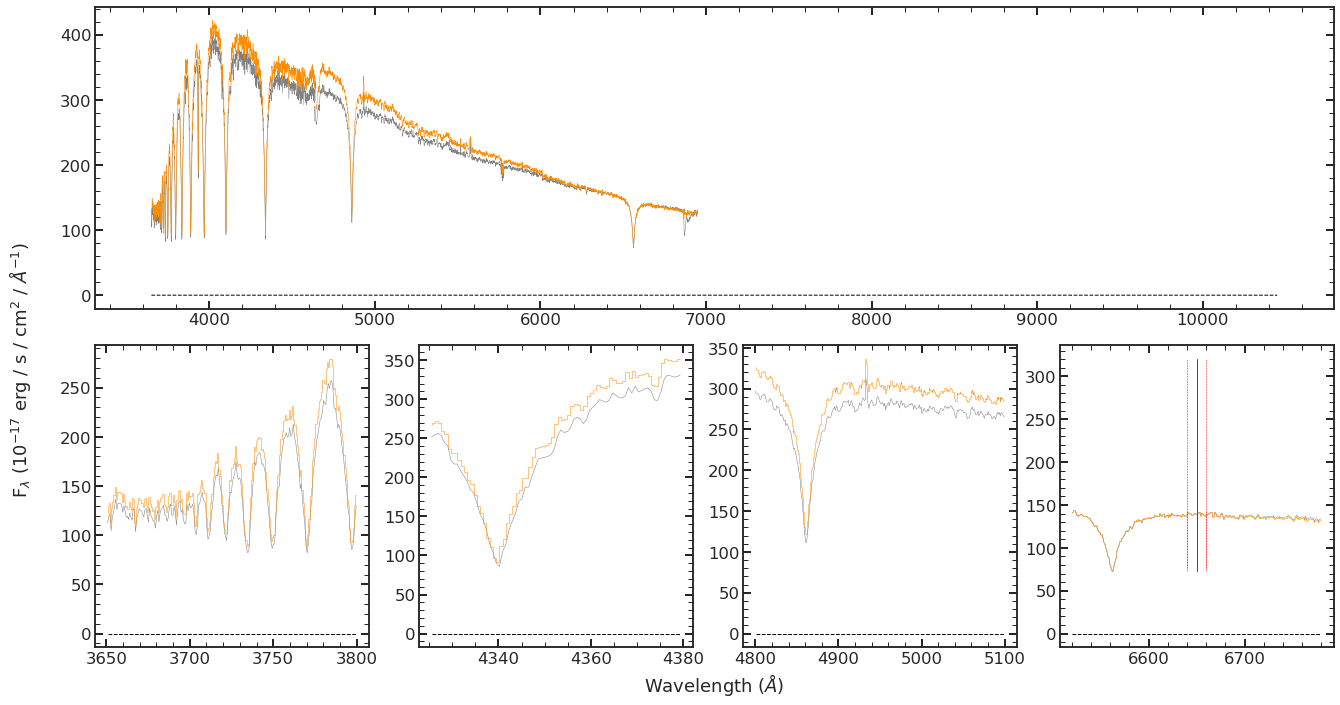

In [5]:
###########################################################################
# List the programs that contain the target(s) you would like to reduce
# If there is more than one program, simply list multiple ensuring that 
# the absolute path is correct.  The path should be the one listed in your
# email notices of new data.
###########################################################################
folders = ['/work/03946/hetdex/maverick/LRS2/ENG21-1-000/']

###########################################################################
# This section includes several key parameters for you to set to execute
# your reductions.  This includes the object name (as submitted), lists
# of observations that you would like to ignore (perhaps bad weather or
# coordinates). The wavelength you would like to run object detection.
# For emission line galaxies, you can include the redshift, which is used
# to mask physical lines to avoid self-subtraction in the sky subtraction
# step.  If redshift does not make sense, or is unknown for your target,
# you should be safe setting it to zero.  The wave window is the full extent
# in Anstroms of the detection window (detwave +/- wave_window/2.).  The
# function that collapses that wavelength window for detection is "func"
# The extraction_radius is in arcseconds and is an aperture extraction for
# the target spectrum.  The sky_radius defines the sky fibers (>sky_radius
# from target center).  The object_radius is used in the "local" sky and is
# the masking radius for smoothing the sky background at each wavelength.
# There are two detection channels for LRS2B and R, and the detwave needs
# to be in the supported channel.  When observing with both B+R and you would
# like to combine the channels, choose a wavelength between 6450-6950A.  
###########################################################################
exclude_folder = ['']
objectname = 'srlrs2'
detwave = 6650.
redshift = 0. # detwave / 6562.8
wave_window= 20.
extraction_radius = 1.5
sky_radius = 3.5
object_radius = 2.0
red_detect_channel = 'red'
blue_detect_channel = 'orange'
func = np.nanmean

###########################################################################
# Here we define physical lines typically associated with 
# emission line galaxies.
###########################################################################
lines = [2796., 2803., 3726.1, 3729.1, 3889., 4101.76, 4340.5,
         4363.2, 4861.3, 4958.9, 5006.8, 6562.8, 6716.5, 6730.8, 
         6548., 6583.4]

###########################################################################
# We grab the filenames related to the target and folders provided.
# If none are found, the programs exits without further adieu.
###########################################################################
filenames, names = get_scifiles_from_folder(folders, 
                                            object_name=objectname, 
                                            exclude_folder=exclude_folder)
if len(filenames) == 0:
    print('No files found for %s' % objectname)
    sys.exit('Trying to exit gracefully')
    
###########################################################################
# We load the telluric models for the 16th, 50th, and 84th percentile
# empirically measured telluric absorption.  These were constructed
# from HR standard stars and you can select 0, 1, or 2 in ".data[X]"
###########################################################################
telcor_fits = fits.open('lrs2_avg_telluric.fits')
telcor = telcor_fits[0].data[2]

###########################################################################
# A newly derived response correction to the standard 2019 response curves
# was constructed over a year of standard stars (May 2021-2022).  I suggest
# using the response correction as listed here. 
###########################################################################
new_response = fits.open('response_correction.fits')
response = new_response[0].data[1]
wsel = ((def_wave>9000) * (def_wave<10050)) + (def_wave<3800) + (def_wave>10200)
response = np.interp(def_wave, def_wave[~wsel], response[~wsel])

###########################################################################
# Here the reduction begins.  We first initiate an LRS2Object class for
# our filenames and parametters.
###########################################################################
LRS2 = LRS2Object(filenames, detwave=detwave, wave_window=wave_window,
                  red_detect_channel=red_detect_channel,
                  blue_detect_channel=blue_detect_channel,
                  ignore_mask=False)

###########################################################################
# We then perform a simple sky subtraction.  The most common edits are 
# setting local=True, and pca=False.  Other parameters can be inspected with
# help(LRS2.subtract_sky)
###########################################################################
LRS2.subtract_sky(func=np.nansum, local=False, pca=False, correct_ftf_from_skylines=False,
                  sky_radius=sky_radius, obj_radius=object_radius,
                  ncomp=25, bins=25, peakthresh=2., pca_iter=3)

# Set astrometry
LRS2.get_astrometry()

# Extract spectrum for each observation
LRS2.extract_spectrum(radius=extraction_radius)

# Smooth the LRS2-R resolution to match the orange and red channels together
LRS2.smooth_resolution(redkernel=1.8, bluekernel=0.1)

# Rectify all spectra to a common wavelength
LRS2.rectify(def_wave)

# Normalize the spectra using the detwave and wave_window. 
# This step can be skipped if the S/N is quite low and the native
# calibration is a better option
LRS2.normalize(detwave=detwave, wave_window=wave_window, func=func)

# Calculate the S/N at the detwave to estimate the weights for a weighted
# combined spectrum
LRS2.calculate_sn()

# Combine the multiple spectra into a single spectrum using the S/N as weights
LRS2.combine_spectra()

# Correct the combined spectrum for the new response
LRS2.spec1D =  LRS2.spec1D * response

# Write the combined spectrum including the telluric correction as a column
LRS2.write_combined_spectrum(telcor=telcor)

# Inspect the reductions with 2D collapsed plots
LRS2.setup_plotting()
for key in LRS2.sides.keys():
    for L in LRS2.sides[key]:
        if (L.channel == blue_detect_channel) or (L.channel == red_detect_channel):
            L.plot_image(radius=extraction_radius, func=func, attr='skysub', quick_skysub=False,
                         sky_radius=sky_radius, wave_window=wave_window)
LRS2.fig.savefig('%s_image_plot.png' % objectname, dpi=150)

# Make a single combine cube.  Use help(LRS2.make_cube) for more info
#LRS2.make_cube(def_wave, ran=[-7., 7., -7., 7.])
#LRS2.combine_cubes()
#LRS2.spec3D =  LRS2.spec3D * response
#LRS2.spec3D =  LRS2.spec3D / telcor
#LRS2.write_cube(outname=(objectname + '_combined_cube.fits'))

# 1D extracted spectrum plotting
# Adjust the five wavelength windows in "wran" to your desire
wran = [[3650, 10450], [3650, 3800], [4325, 4380], [4800, 5100], [6520, 6780]]

fig, ax = plt.subplots(5, 1, figsize=(20, 10))
ax[0].set_position([0.1, 0.55, 0.86, 0.42])
ax[1].set_position([0.1, 0.08, 0.19, 0.42])
ax[2].set_position([0.325, 0.08, 0.19, 0.42])
ax[3].set_position([0.55, 0.08, 0.19, 0.42])
ax[4].set_position([0.77, 0.08, 0.19, 0.42])

for i, wr in enumerate(wran):
    wave = LRS2.spec1D.spectral_axis.value
    flux =  LRS2.spec1D.flux.value
    error = LRS2.spec1D.uncertainty.array
    wsel = (wave > wr[0]) * (wave < wr[1])
    ax[i].step(wave[wsel], flux[wsel]/1e-17/telcor[wsel], color='darkorange', lw=0.5, alpha=1.0, zorder=2)
    ax[i].plot(wave[wsel], wave[wsel]*0., 'k--', lw=1, zorder=2)
    for key in LRS2.sides.keys():
        for L in LRS2.sides[key]:
            wsel = (L.spec1D.spectral_axis.value > wr[0]) * (L.spec1D.spectral_axis.value < wr[1])
            ax[i].plot(L.spec1D.spectral_axis.value[wsel], L.spec1D.flux.value[wsel]/1e-17, color='grey', lw=0.5, zorder=1)
    if (detwave > wr[0]) * (detwave < wr[1]):
        li = np.nanpercentile(L.spec1D.flux.value[wsel]/1e-17, 0.1)
        hi = np.nanpercentile(L.spec1D.flux.value[wsel]/1e-17, 99.9)
        plt.plot([detwave, detwave], [li, hi], 'r-', lw=1)
        plt.plot([detwave+wave_window/2., detwave+wave_window/2.], [li, hi], 'r--', lw=0.5)
        plt.plot([detwave-wave_window/2., detwave-wave_window/2.], [li, hi], 'r--', lw=0.5)
    f_ax10 = ax[i]
    f_ax10.tick_params(axis='both', which='both', direction='in')
    f_ax10.tick_params(axis='y', which='both', left=True, right=True)
    f_ax10.tick_params(axis='x', which='both', bottom=True, top=True)
    f_ax10.tick_params(axis='both', which='major', length=8, width=2)
    f_ax10.tick_params(axis='both', which='minor', length=5, width=1)
    f_ax10.minorticks_on()

ax[0].set_ylabel(r'F$_{\lambda}$ (10$^{-17}$ erg / s / cm$^2$ / $\AA^{-1}$)')
ax[0].yaxis.set_label_coords(-0.05, -0.2)
ax[0].set_xlabel(r'Wavelength ($\AA$)')
ax[0].xaxis.set_label_coords(0.5, -1.2)
plt.savefig('%s_spectrum_plot.png' % objectname, dpi=150)